In [20]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
from datasets.seq_mnist import SequentialMNIST_double
from datasets import seq_mnist as sm

import models.seqae as seqae
import models.base_networks as bn 
import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev



import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

playground_path = os.path.join(result_dir, '20220913_playground_model')


print(os.path.exists(playground_path))

print(nb.filter_list('double', os.listdir(result_dir)))
targpath = os.path.join(result_dir, '20221104_mnist_double_0')
print(os.path.exists(targpath))

True
['20221031_double_mnist_two_0', '20221104_mnist_double_0', '20221103_mnist_double_0', '20221101_mnist_double_0', '20221031_double_mnist_0', '20221101_mnist_double_two_0']
True


In [21]:

targlist = os.listdir(targpath)

targlist = nb.model_exists(targlist,  targpath)
print(targlist)

['same_objectFalse_dim_m256', 'same_objectFalse_dim_m512', 'same_objectFalse_dim_m128', 'same_objectTrue_dim_m256', 'same_objectTrue_dim_m128', 'same_objectTrue_dim_m512']


In [22]:
reload(ev)
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 30
n_cond = 2
device =0
predictive = False
reconstructive = False
repeats=3


targdir_pathlist = [ '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128']
print(targdir_pathlist)

reload(ev)
reload(bn)
allresults, targ, xnext = ev.prediction_evaluation(targdir_pathlist, device=0,
                                                                        n_cond=2,
                                                                        tp=tp,
                                                                    repeats=1,
                           predictive= False , reconstructive = False)

results = allresults['results']


['/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128']
{'args': {'T': 32, 'backgrnd': False, 'max_T': 32, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': True, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': False, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:39<00:00,  4.64it/s]


tensor([ 0.9644,  1.1139,  1.5641,  1.9524,  2.2209,  2.5025,  3.0123,  3.5082,
         3.9049,  4.2839,  4.8103,  5.3098,  5.7664,  6.1938,  6.6670,  7.2073,
         7.6317,  8.1101,  8.5986,  9.0960,  9.5418, 10.0159, 10.5341, 11.0198,
        11.5024, 11.9941, 12.4739, 12.9533, 13.3955, 13.9299])


In [23]:
from utils import optimize_bd_cob as obc 
reload(obc)
checkmodelpath = targdir_pathlist[0]
Ms = allresults['Ms'][checkmodelpath]
normalize=False
ChangeB= obc.optimize_bd_cob(Ms,  lr=0.1, epochs_monitor=10, n_epochs=100, normalize=True) 

ep:9 loss:7.033788580471667
ep:19 loss:7.020079759978464
ep:29 loss:7.014389009191663
ep:39 loss:7.0095741765950486
ep:49 loss:7.008308885686
ep:59 loss:7.005870927812627
ep:69 loss:7.003786872568623
ep:79 loss:7.002050083249205
ep:89 loss:7.000823423495973
ep:99 loss:7.000617842362458


In [24]:
PMPs = ChangeB(Ms)


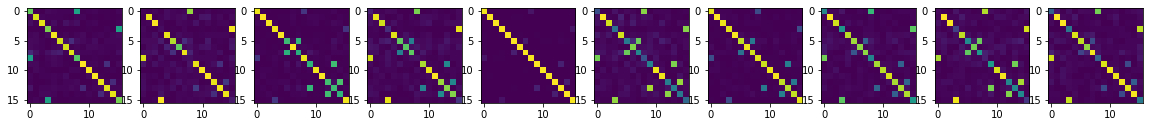

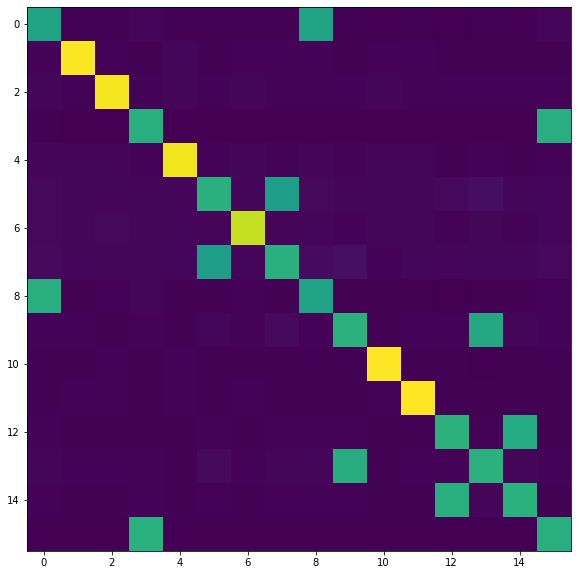

In [25]:
plt.figure(figsize=(20, 20))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(torch.abs(PMPs[k]).detach().to('cpu'))
    
plt.figure(figsize=(10, 10))
plt.imshow(torch.mean(torch.abs(PMPs.detach()), axis=0))



In [26]:
reload(obc)
selections = obc.obtain_blocks(torch.mean(torch.abs(PMPs.detach()), axis=0))
print(selections)
selection = selections[3]
print(selection)


14 2 2
13 1 3
12 1 4
10 2 6
9 1 7
7 2 9
6 1 10
4 2 12
3 1 13
2 1 14
0 2 16
[[0, 8], [1], [2], [3, 15], [4], [5, 7], [6], [9, 13], [10], [11], [12, 14]]
[3, 15]


In [27]:
from utils import optimize_lasso as ol
reload(ol)
myconfig = allresults['configs'][checkmodelpath]
analysis_out = ol.optimize_cov_blocks_inter(myconfig, ChangeB, selection_dim=[1, 10], verbose=True, )





183
ep:0 loss:107.87910448918578
ep:1 loss:106.10202072226936
ep:2 loss:106.08294915371253
ep:3 loss:106.05419746774142
ep:4 loss:106.08831657868265
ep:5 loss:106.05040065577772
ep:6 loss:106.01982287631009
ep:7 loss:106.12245003121798
ep:8 loss:106.09098007118767
ep:9 loss:106.12088221148716
ep:10 loss:106.06578009766959
ep:11 loss:106.05976984409686
ep:12 loss:106.12202482796758
ep:13 loss:106.0508096830441
ep:14 loss:106.10378865726659
ep:15 loss:106.04970000220126
ep:16 loss:106.0441049878063
ep:17 loss:106.1264774760262
ep:18 loss:106.05441592690723
ep:19 loss:106.02135713504312
ep:20 loss:106.11816168613122
ep:21 loss:106.12175404699774
ep:22 loss:106.10362693911694
ep:23 loss:106.09453924627252
ep:24 loss:106.14417804655481
ep:25 loss:106.08148368460233
ep:26 loss:106.04852899436742
ep:27 loss:106.07267481902909
ep:28 loss:106.07030470384275
ep:29 loss:106.0570707477507


In [29]:
import pickle
with open('./covblock_out.pkl', 'wb') as handle:
    pickle.dump(analysis_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
